# Covid Proof Table Positioning

In [1]:
# We base ourselves on the paper of Goncalves et al. at:
# https://doi.org/10.1016/j.ejor.2020.04.028
# This is a MIP formulation, which we will convert to a QUBO formulation for execution on a dwave machine.
# A QUBO is a Quadratic Unconstrainted Binary Optimisation problem. 
# All variables are binaries,
# (or sometime integers composed out of binaries, encoded in a particular way (one hot or as an unsigned int, etc.))
# They occur either as linear terms or quadratic terms (but note that x = x^2 for binary x).
# They are unconstrained, so only the objective function has to be formulated.
# When transforming from a MIP with constraints, the constraints have to be converted 
# into (weight balanced) terms in the objective function.
# For this conversion, we use the pyqubo library, at https://pyqubo.readthedocs.io/en/latest/
# which was written by recruit-communications. The resulting qubo datastructure 
# can be sent to a dwave computer to be solved.
# Some principles of the basics of the conversion principles of the pyqubo library are explained at:
# http://www.optimization-online.org/DB_FILE/2018/11/6923.pdfimport math

# The objective function of the MIP is: 
# sum_{i=1}^N   sum_{t=1}^{T}  V^t I_{i}^{t}, 
# where T is the set of table types,
# N^t is the nymber of table of type t,
# N is the total number of tables of any (generic) type (N = max_t{N^t})
# V^t is the value of each placed table of type t 
# and I_{i}^{t} is the boolean variable that is 1 if table i is of type t and placed in the room, otherwise it's 0.

In [2]:
import math 
import pprint
import svgwrite
import json

filename_prefix = 'CovidProofPositioning'

# we reduce the problem to stay below 119 qubits.
cfg = { 'room': {'dy':4, 'dx': 10, 'color':'green'},
        'rectangle_types': {'wide': {'dy': 1.2, 'dx':2.0, 'value':1.0, 
                                    'max_number':6, 'color':'blue'}, # 1st table type
                            'sqish': {'dy': 1.4, 'dx':1.4, 'value':4.0, 
                                 'max_number':6, 'color':'orange'}, # 2nd table type
                            'high': {'dy': 3, 'dx':1, 'value':2.0, 
                                 'max_number':6, 'color':'brown'}, # 2nd table type
                           },
       }

smaller_example = True
if smaller_example:
    cfg = { 'room': {'dy':4, 'dx': 10, 'color':'green'},
            'rectangle_types': {'wide': {'dy': 1.2, 'dx':2.0, 'value':1.0, 
                                        'max_number':1, 'color':'blue'}, # 1st table type
                                'sqish': {'dy': 1.4, 'dx':1.4, 'value':1.0, 
                                     'max_number':1, 'color':'orange'}, # 2nd table type
                               },
           }

# For the 'ann_hw' hardware dwave machine, I get:
# ValueError: Cannot embed given BQM (size 136), sampler can only handle problems of size 119
smallest_example = True
if smallest_example:
    cfg = { 'room': {'dy':2, 'dx': 2, 'color':'green'},
            'rectangle_types': {'wide': {'dy': 0.4, 'dx':0.8, 'value':1.0, 
                                        'max_number':1, 'color':'blue'}, # 1st table type
                                'sqish': {'dy': 1.2, 'dx':0.6, 'value':1.0, 
                                     'max_number':1, 'color':'orange'}, # 2nd table type
                               },
          }
    
cfg_json_str = json.dumps(cfg, indent=2)
print(cfg_json_str)

{
  "room": {
    "dy": 2,
    "dx": 2,
    "color": "green"
  },
  "rectangle_types": {
    "wide": {
      "dy": 0.4,
      "dx": 0.8,
      "value": 1.0,
      "max_number": 1,
      "color": "blue"
    },
    "sqish": {
      "dy": 1.2,
      "dx": 0.6,
      "value": 1.0,
      "max_number": 1,
      "color": "orange"
    }
  }
}


In [3]:
resolution_in_m = 0.1  
# The finer the resolution, the more bits needed, so this will be one control parameter
# that allows to scale the needed bits up or down when possible resp. needed.
n_x_steps = math.ceil(cfg['room']['dx'] / resolution_in_m)
n_y_steps = math.ceil(cfg['room']['dy'] / resolution_in_m)
print('n_x_steps={:d} is the number of steps for the room-range horizontal x coordinate variable of each table.'.format(n_x_steps))
print('n_y_steps={:d} is the number of steps for the room-range vertical y coordinate variable of each table.'.format(n_y_steps))
#n_bits_y = math.ceil(math.log(n_y_steps, 2))
#n_bits_x = math.ceil(math.log(n_x_steps, 2))
#print(n_y_steps, n_bits_y, n_x_steps, n_bits_x)

n_x_steps=20 is the number of steps for the room-range horizontal x coordinate variable of each table.
n_y_steps=20 is the number of steps for the room-range vertical y coordinate variable of each table.


In [4]:
# room parameters:
W = cfg['room']['dx'] / resolution_in_m
H = cfg['room']['dy'] / resolution_in_m

# table type parameters:
Wt = {}
Ht = {}
Vt = {}
Nt = {}
N = 0
Wt_max = 0
Ht_max = 0
max_mip_obj = 0
for (t, (_, table_type)) in enumerate(cfg['rectangle_types'].items()):
    Wt[t] = int(table_type['dx'] / resolution_in_m + 0.5)
    Ht[t] = int(table_type['dy'] / resolution_in_m + 0.5)
    Vt[t] = table_type['value']
    Nt[t] = table_type['max_number']
    assert int(Nt[t]) == Nt[t]
    N += Nt[t]
    Wt_max = max(Wt_max, Wt[t])  # TODO: Not doing anything with 90 degree rotation yet.
    Ht_max = max(Ht_max, Ht[t])  # TODO: Not doing anything with 90 degree rotation yet.
    max_mip_obj += Nt[t] * Vt[t]  # supposing all tables can fit.
print('Wt=')
print(Wt)
print('Ht=')
print(Ht)
print('N={:d} is the maximum number of potentially placeble tables for all table types summed together.'.format(N))
print('Wt_max={:f} is the maximum width amongst all table types.'.format(Wt_max))
print('Ht_max={:f} is the maximum width amongst all table types.'.format(Ht_max))
print('max_mip_obj={:f} is (an upperbound for) the maximum value the ob]ective could ever reach.'.format(max_mip_obj))
P = max_mip_obj * 1.25   # we set the penaly P to this value so that hard MIP constraints,
# present in the QUBO model as terms in the QUBO ob]ective to be minimised, are more highly weighted that the
# value the ob]ective can reach.
print('P={:f} is the penalty weight factor we weight all MIP constraints (so other QUBO obj[m] terms) with.'.format(P))
        
n_w_steps = math.ceil(Wt_max)
n_h_steps = math.ceil(Ht_max)
print('n_w_steps={:d} is the number of steps for the table-range horizontal w size variable of each table.'.format(n_w_steps))
print('n_h_steps={:d} is the number of steps for the table_range vertical h size variable of each table.'.format(n_h_steps))

Wt=
{0: 8, 1: 6}
Ht=
{0: 4, 1: 12}
N=2 is the maximum number of potentially placeble tables for all table types summed together.
Wt_max=8.000000 is the maximum width amongst all table types.
Ht_max=12.000000 is the maximum width amongst all table types.
max_mip_obj=2.000000 is (an upperbound for) the maximum value the ob]ective could ever reach.
P=2.500000 is the penalty weight factor we weight all MIP constraints (so other QUBO obj[m] terms) with.
n_w_steps=8 is the number of steps for the table-range horizontal w size variable of each table.
n_h_steps=12 is the number of steps for the table_range vertical h size variable of each table.


In [5]:
# Create variables dictionaries, model dictionary and objective dictionary.

# Create all the variable dictionaries
# We call the Goncalves paper 'I' boolean variables 'b' here instead.
b = {}  # (i,t) bin 
# The rest of the naming is consistent with the Goncalves paper.
x = {}  # (i) int
y = {}  # (i) int
p = {}  # (i,j) bin
q = {}  # (i,j) bin
w = {}  # (i) int
h = {}  # (i) int
s2x = {}  # (i,j) int
s3x = {}  # (i,j) int
s4y = {}  # (i,j) int
s5y = {}  # (i,j) int
s10xL = {} # (i) int
s10xR = {} # (i) int
s11yL = {} # (i) int
s11yR = {} # (i) int
s12 = {}  # (i) bin
s15 = {} # (t) int
model = {} # can be mip model 
# or an annealing model (where sim sw or real harware have same model type as interface)
obj = {}

# We are going to set up problems, not only for a quantum computer,
# but, just to check if our model is correct, via a trustable MIP solver: Gurobi.
# We will maximise sharing of code of this Gurobi problem with the quantum QUBO formulation,
# so that we have a method to avoid mistakes in the more tricky and less well known QUBO formulation.
# 'mip' means we formulate a MIP (mixed integer programming) model. We do this using the Gurobi API.
# 'ann_sw' means ANNealing_via_simulator_SoftWare
# 'ann_hw' annealing_via_quantum_HardWare
all_implemented_methods = ['mip_plain', 'mip_qubo', 'ann_sw', 'ann_hw']
run_methods = ['mip_plain', 'mip_qubo', 'ann_sw', 'ann_hw'] # , 'ann_sw']
# If you do not have a gurobi license, just leave out 'mip' form the run_methods.
# If you have not downloaded the free leap software from dwave, just leave out 'ann_sw' form the run_methods.
# If you have not applied and been granted access to the quantum computers at dwave, 
# just leave out 'ann_hw' form the run_methods.

assert set(run_methods).issubset(all_implemented_methods)

def complete_name_with_indices(name_prefix, indices):
    anonymous_indices = False
    name = name_prefix
    n_indices = 0
    for index_name, index_value in indices.items():
        if anonymous_indices:
            name += '_{:d}'.format(index_value) 
        else:
            name += '_{:s}{:d}'.format(index_name, index_value)
        n_indices += 1
    return name, n_indices

def add_var(dictionary, method, var_name, lb, ub, mip_model, indices):  
    # this can be an integer (in annealing methods) or a float (in mip method)
    full_var_name, n_indices = complete_name_with_indices(var_name, indices)
    binary = lb==0 and ub==1
    annealing = method in ['ann_sw', 'ann_hw']
    if annealing:
        if binary:  # add a binary variable
            v = Binary(full_var_name)
        else:
            v = LogEncInteger(full_var_name, (lb, ub))
    else:  # integers or floats, depending on the method.
        assert mip_model is not None
        obj_coefficient = 0.0  # for equivalence of mip method to the annealing methods 
        # We exclude non zero obj_coefficients.
        if binary:  # add a binary variable
            v = mip_model.addVar(lb, ub, obj_coefficient, GRB.BINARY, full_var_name)
        else:
            prefer_continuous = True  # integermimicks the quantum discrete nature better, 
            # continuous is likely quicker
            var_type = GRB.CONTINUOUS if prefer_continuous else GRB.INTEGER
            v = mip_model.addVar(lb, ub, obj_coefficient, GRB.CONTINUOUS, full_var_name)

    index_value_list = []
    for index_name, index_value in indices.items():
        index_value_list.append(index_value)
        if n_indices == 1:
            dictionary[m][index_value_list[0]] = v
        else:
            assert n_indices == 2
            if len(index_value_list) == 2:
                dictionary[m][(index_value_list[0],index_value_list[1])] = v
                
    #if n_indices == 1:
    #    index_1_value = indices[0]
    #    dictionary[m][i] = v
    #elif n_indices == 2:
    #    dictionary[m][(i,j)] = v
    #else:
    #    assert False
        
    return v

for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    b[m] = {}  # (i,t) bin 
    x[m] = {}  # (i) int
    y[m] = {}  # (i) int
    p[m] = {}  # (i,j) bin
    q[m] = {}  # (i,j) bin
    w[m] = {}  # (i) int
    h[m] = {}  # (i) int
    s2x[m] = {}  # (i,j) int
    s3x[m] = {}  # (i,j) int
    s4y[m] = {}  # (i,j) int
    s5y[m] = {}  # (i,j) int
    s10xL[m] = {} # (i) int
    s10xR[m] = {} # (i) int
    s11yL[m] = {} # (i) int
    s11yR[m] = {} # (i) int
    s12[m] = {}  # (i) bin
    s15[m] = {} # (t) int
    
    model[m] = None  # different type of model for mip and for annealing
    # obj[m] is initialized in the next cell below.        

    if m in ['mip_plain', 'mip_qubo']:
        import gurobipy as gp
        a = False  # you can read isq as must do annealing stuff (i.o mip)
        from gurobipy import GRB
        model[m] = gp.Model()
    elif m in ['ann_sw', 'ann_hw']:
        from pyqubo import LogEncInteger, Binary, Constraint
        import dimod
        a = True # you can read 1 as must do annealing stuff (i.o mip)
        model[m] = None  # nothing needed here yet. We will fill it with an annealing model later.
    else:
        assert False

    for i in range(N):
        assert isinstance(i, int)
        
        # Note that in this loop. model[m], the rhs is only not None for where m is 'mip', so:
        if m in ['mip_plain', 'mip_qubo']:
            assert model[m] is not None
        else:  # annealing / QUBO model
            assert model[m] is None
        
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            #b[m][(i,t)] = Binary('b_{:d}_{:d}'.format(i,t))
            add_var(b, m, 'b', 0.0, 1.0, model[m], {'i': i, 't':t})
            
        #x[m][i] = LogEncInteger('x_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(x, m, 'x', 0, n_x_steps, model[m], {'i': i})  # dropped -1
        
        #y[m][i] = LogEncInteger('y_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(y, m, 'y', 0, n_y_steps, model[m], {'i': i})  # dropped -1
        
        #w[m][i] = LogEncInteger('w_{:d}'.format(i), (0.0, n_w_steps-1))
        add_var(w, m, 'w', 0, n_w_steps, model[m], {'i': i})  # dropped -1

        #h[m][i] = LogEncInteger('h_{:d}'.format(i), (0.0, n_h_steps-1))
        add_var(h, m, 'h', 0, n_h_steps, model[m], {'i': i})  # dropped -1

        #s10xL[m][i] = LogEncInteger('s10xL_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(s10xL, m, 's10xL', 0, n_x_steps, model[m], {'i': i})  # dropped -1

        #s10xR[m][i] = LogEncInteger('s10xR_{:d}'.format(i), (0.0, n_x_steps-1))
        add_var(s10xR, m, 's10xR', 0, n_x_steps, model[m], {'i': i})  # dropped -1

        #s11yL[m][i] = LogEncInteger('s11yL_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(s11yL, m, 's11yL', 0, n_y_steps, model[m], {'i': i})  # dropped -1

        #s11yR[m][i] = LogEncInteger('s11yR_{:d}'.format(i), (0.0, n_y_steps-1))
        add_var(s11yR, m, 's11yR', 0, n_y_steps, model[m], {'i': i})  # dropped -1

        #s12[m][i] = Binary('s12_{:d}'.format(i))
        add_var(s12, m, 's12', 0, 1, model[m],  {'i': i})

        for j in range(i+1, N):
            assert i < j
            #p[m][(i,j)] = Binary('p_{:d}_{:d}'.format(i,j))
            add_var(p, m, 'p', 0, 1, model[m], {'i': i, 'j': j})

            #q[m][(i,j)] = Binary('q_{:d}_{:d}'.format(i,j))
            add_var(q, m, 'q', 0, 1, model[m],  {'i': i, 'j': j})

            # TODO: with the 2* range extention for the slack vars below, we get feasibility when 
            # more than one table is allowed, otherwise not. Strange. To be fixed...
            
            #s2x[m][(i,j)] = LogEncInteger('s2x_{:d}_{:d}'.format(i,j), (0.0, n_x_steps-1))
            # 0.18 goes ok, 0.17 goes wrong for ioOne. At least for slack debug case in cfg.
            ioOne = 2 # TODO: I would think 1.0 should be enough. Investigate why we need more...
            add_var(s2x, m, 's2x', 0, ioOne*n_x_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s3x[m][(i,j)] = LogEncInteger('s3x_{:d}_{:d}'.format(i,j), (0.0, n_x_steps-1))
            add_var(s3x, m, 's3x', 0, ioOne*n_x_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s4y[m][(i,j)] = LogEncInteger('s4y_{:d}_{:d}'.format(i,j), (0.0, n_y_steps-1))
            add_var(s4y, m, 's4y', 0, ioOne*n_y_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

            #s5y[m][(i,j)] = LogEncInteger('s5y_{:d}_{:d}'.format(i,j), (0.0, n_y_steps-1))
            add_var(s5y, m, 's5y', 0, ioOne*n_y_steps, model[m], {'i': i, 'j': j})  # dropped -1, replaced with 2*

    for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
        #s15[m][t] = LogEncInteger('s15_{:d}'.format(t), (0.0, nt[t]-1))
        add_var(s15, m, 's15', 0, Nt[t], model[m], {'t': t})  # dropped -1


-------------------- mip_plain --------------------
Using license file /Library/gurobi910/gurobi.lic

-------------------- mip_qubo --------------------

-------------------- ann_sw --------------------

-------------------- ann_hw --------------------


In [6]:
#print(b)

In [7]:
#print(x)

In [8]:
#print(y)
run_methods

['mip_plain', 'mip_qubo', 'ann_sw', 'ann_hw']

In [9]:
# Create constraints, which are real constraints for the mip model,
# but just penalised terms for the annealing models.

def add_constr(obj_m, penalty, expr_to_be_zero_or_minimized, method, constr_name,
               mip_model, indices):
    weighted_qt = 0  # This is the start for all branches in here.
    full_constr_name, n_indices = complete_name_with_indices(constr_name, indices)        
    annealing = method in ['ann_sw', 'ann_hw']
    if annealing:  # QUBO models have no constraints. 
        # The best we can do is penalise the non-euqality part in th obj[m]
        weighted_qt = penalty * Constraint(expr_to_be_zero_or_minimized ** 2, label=full_constr_name) 
        #obj_m += weighted_qt
        # a QUBO 'constraint'
    else:  # mip
        assert m in ['mip_plain', 'mip_qubo']
        if m == 'mip_plain':  # normal mip mode
            mip_model.addConstr(expr_to_be_zero_or_minimized == 0, full_constr_name) 
            # a real mip constraint
            assert weighted_qt == 0
        else:
            assert m == 'mip_qubo'
            print('Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name={:s}, Penalty={:.4f}.'.\
                  format(constr_name, penalty))
            print('indices =')
            print(indices)
            quadratic_term = expr_to_be_zero_or_minimized * expr_to_be_zero_or_minimized
            weighted_qt = penalty * quadratic_term
            print('adding weighted_qt=')
            #print(weighted_qt)
            #obj_m += weighted_qt  # just as the qubo does
    return weighted_qt  # we could do addition of this to obj_m in place, but somehow this fails.
    # so we do it in the caller instead.
            

# Build up original MIP objective (without terms for (energy terms of) constraints).
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    assert isinstance(i, int)

    # Note that in this loop. mip_model=model[m], the rhs is only not None for where m is 'mip', so:
    if m in ['mip_plain', 'mip_qubo']:
        assert model[m] is not None
    else: # annealing / QUBO model
        assert model[m] is None
            
    obj[m] = 0  # That's where it starts for both model types: mip or annealing.
    for i in range(N):
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            obj[m] += b[m][(i,t)] * Vt[t]  # This holds for both mip and annealing models.
            # For mip models, the objective is complete here, and the rest to add below is constraints.
            # For QUBO (annealing) models, we add the 'constraints' as penalised objective terms below.

    # Complete the objective from MIP objective to QUBO objective.
    for i in range(N):
        for j in range(i+1, N):
            assert i < j
            lin2_ij = 2*( x[m][i] - x[m][j] + W * (p[m][i,j] + q[m][i,j]) - s2x[m][(i,j)] ) - (w[m][i]+w[m][j])
            #obj[m] += P * Constraint(lin2_ij ** 2, label='eq2_{:d}_{:d}'.format(i,j)) # eq (2)
            obj[m] += add_constr(obj[m], P, lin2_ij, m, 'eq2', model[m], {'i': i, 'j': j})
            
            lin3_ij = 2*( x[m][j] - x[m][i] + W * (1-p[m][i,j] + q[m][i,j]) - s3x[m][(i,j)] ) - (w[m][i]+w[m][j])
            #obj[m] += P * Constraint(lin_3_ij ** 2, label='eq3_{:d}_{:d}'.format(i,j))  # eq (3)
            obj[m] += add_constr(obj[m], P, lin3_ij, m, 'eq3', model[m], {'i': i, 'j': j})
            
            lin4_ij = 2*( y[m][i] - y[m][j] + H * (  p[m][i,j] + 1-q[m][i,j]) - s4y[m][(i,j)] ) - (h[m][i]+h[m][j])
            #obj[m] += P * Constraint(lin4_ij ** 2, label='eq4_{:d}_{:d}'.format(i,j))  # eq (4)
            obj[m] += add_constr(obj[m], P, lin4_ij, m, 'eq4', model[m], {'i': i, 'j': j})
            
            lin5_ij = 2*( y[m][j] - y[m][i] + H * (1-p[m][i,j] + 1-q[m][i,j]) - s5y[m][(i,j)] ) - (h[m][i]+h[m][j])
            #obj[m] += P * Constraint(lin5_ij ** 2, label='eq5_{:d}_{:d}'.format(i,j))  # eq (5)
            obj[m] += add_constr(obj[m], P, lin5_ij, m, 'eq5', model[m], {'i': i, 'j': j})

        lin10L_i = (w[m][i]/2 + s10xL[m][i] - x[m][i])
        #obj[m] += P * Constraint(line10L ** 2, label='eq10L_{:d}'.format(i))  # eq (10 left), for all i
        obj[m] += add_constr(obj[m], P, lin10L_i, m, 'eq10L', model[m], {'i': i})
        
        lin10R_i = (x[m][i] + s10xR[m][i] - W + w[m][i]/2)
        #obj[m] += P * Constraint(lin10R_i ** 2, label='eq10R_{:d}'.format(i))  # eq (10 right), for all i
        obj[m] += add_constr(obj[m], P, lin10R_i, m, 'eq10R', model[m], {'i': i})
        
        lin11L_i = (h[m][i]/2 + s11yL[m][i] - y[m][i])
        #obj[m] += P * Constraint(lin11L_i ** 2, label='eq11L_{:d}'.format(i))  # eq (11 left), for all i
        obj[m] += add_constr(obj[m], P, lin11L_i, m, 'eq11L', model[m], {'i': i})
        
        lin11R_i = (y[m][i] + s11yR[m][i] - H + h[m][i]/2)
        #obj[m] += P * Constraint(lin11R_i ** 2, label='eq11R_{:d}'.format(i))  # eq (11 right), for all i
        obj[m] += add_constr(obj[m], P, lin11R_i, m, 'eq11R', model[m], {'i': i})

        lin12_i = 1 - s12[m][i]  # eq (12) 1 - [slack variable] for inequality
        lin13_i = w[m][i]  # eq(13) lhs
        lin14_i = h[m][i]  # eq(14) lhs
        for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
            lin12_i -= b[m][(i,t)]  # eq (12)
            lin13_i -= b[m][(i,t)] * Wt[t]  # eq (13) rhs
            lin14_i -= b[m][(i,t)] * Ht[t]  # eq (14) rhs

        #obj[m] += P * Constraint(lin12_i ** 2, label='eq12_{:d}'.format(i))
        # eq (12): so this lin term is pos & minimal when *at most* one b[(i,t)] is 1. 
        # if none of them is, then s(i,t) must be 1 (at optimality), for all i
        obj[m] += add_constr(obj[m], P, lin12_i, m, 'eq12', model[m], {'i': i})

        #obj[m] += 3 * P * Constraint(lin13_i ** 2, label='eq13_{:d}'.format(i))
        # eq (13): so this lin term is pos & minimal when w[t] = sum_t b[(i,t)]*Wt[t], for all i
        obj[m] += add_constr(obj[m], P, lin13_i, m, 'eq13', model[m], {'i': i})

        #obj[m] += 3 * P * Constraint(lin14 ** 2, label='eq14_{:d}'.format(i))
        # eq (14): so this lin term is pos & minimal when h[t] = sum_t b[(i,t)]*Ht[t], for all i
        obj[m] += add_constr(obj[m], P, lin14_i, m, 'eq14', model[m], {'i': i})

    for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
        lin15_t = Nt[t] - s15[m][t]
        for i in range(N):
            lin15_t -= b[m][(i,t)]
        #obj[m] += P *  Constraint(lin15 ** 2, label='eq15_{:d}'.format(t))
        # eq (15) so this lin term is pos & minimal when Nt[t] = s15[t] + sum_i b[(i,t)], for all t
        obj[m] += add_constr(obj[m], P, lin15_t, m, 'eq15', model[m], {'t': t})

    annealing = m in ['ann_sw', 'ann_hw']
    if annealing:  # special step for annealing QUBO models
        model[m] = obj[m].compile()
    else:
        pass  # nothing to do here for mpi model
    
    #print(obj[m]


-------------------- mip_plain --------------------

-------------------- mip_qubo --------------------
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq2, Penalty=2.5000.
indices =
{'i': 0, 'j': 1}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq3, Penalty=2.5000.
indices =
{'i': 0, 'j': 1}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq4, Penalty=2.5000.
indices =
{'i': 0, 'j': 1}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq5, Penalty=2.5000.
indices =
{'i': 0, 'j': 1}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq10L, Penalty=2.5000.
indices =
{'i': 0}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mimicking_qubo. constr_name=eq10R, Penalty=2.5000.
indices =
{'i': 0}
adding weighted_qt=
Adding extra terms to mip obj_m because of mip_mi

In [10]:
###print(obj[m])

# mip methods:
# input:
required_max_time_limit_s = {}
required_max_time_limit_s['mip_plain'] = 20
required_max_time_limit_s['mip_qubo'] = None  # Should run to the end to avoid violations in hard constraints.
#required_max_time_limit_s['ann_sw'] = None  # idem
#required_max_time_limit_s['ann_hw'] = None  # idem
required_max_mip_gap = {}
required_max_mip_gap['mip_plain'] = None
required_max_mip_gap['mip_qubo'] = None  
#required_max_mip_gap['ann_sw'] = None
#required_max_mip_gap['ann_hw'] = None

# required_max_time_limit_s # (1) Stop after searching this many seconds: [None or a float or int]
# or/and
# required_max_mip_gap  # 0.05 (2) Stop at this or lower fraction [None or a float or int]
# between solution and estimated upperbound:
# , whatever comes first.

# output:
mip_gap_reached = {}
objective_value_reached = {}
solver_time_used_s = {}
feasible = {}

# annealing methods:
# towards output:
bqm = {}
n_samples = {}
sampleset = {}
decoded_samples = {}
best_sample = {}
n_samples['ann_sw'] = 10
n_samples['ann_hw'] = 10

for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    if m in ['mip_plain', 'mip_qubo']:
        model[m].ModelSense = gp.GRB.MAXIMIZE
        model[m].setObjective(obj[m])
        
        assert required_max_time_limit_s[m] is None or \
            isinstance(required_max_time_limit_s[m], float) or \
            isinstance(required_max_time_limit_s[m], int)
        assert required_max_mip_gap[m] is None or \
            isinstance(required_max_mip_gap[m], float) or \
            isinstance(required_max_mip_gap[m], int) 
        
        if required_max_time_limit_s[m] is not None:
            model[m].params.Timelimit = required_max_time_limit_s[m]
        if required_max_mip_gap[m] is not None:
            model[m].params.MIPGap = required_max_mip_gap[m]           
        
        model[m].write(filename_prefix + '_' + m + '_Gurobi.lp')
        
        model[m].optimize()  # with Gurobi
        #status = GRB.Status
        status = model[m].Status
        print('status=')
        print(status)
        if status == GRB.INFEASIBLE:
            feasible[m] = False
            print('Model is infeasible.')
            model[m].computeIIS()
            ilp_filename = filename_prefix + '_mip_Gurobi.ilp'
            model[m].write(ilp_filename)
            print('  -> Wrote out Irreducible Inconsistent Subsystem (IIS) to file: \'{:s}\''.format(ilp_filename))
            ilp_file = open(ilp_filename,'r')
            ilp_contents = ilp_file.read()
            print('\nSo the following equations and/or variable type and/or range limits')
            print('  are the smallest infeasible subset found in the full model.\n')
            print('*** ilp_contents begin ***')
            print(ilp_contents)
            print('*** ilp_contents end ***')
            ilp_file.close()
            assert False
        else:
            assert status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.USER_OBJ_LIMIT]
            feasible[m] = True
            
            if status == GRB.OPTIMAL:
                print('Model is solved optimally.')
            elif status == GRB.TIME_LIMIT:
                print('Model solving was interrupted at reaching of user specified time limit.')
            elif status == GRB.USER_OBJ_LIMIT:
                print('Model solving was interrupted at reaching of user specified mip gap limit.')
                
            objective_value_reached[m] = model[m].objVal
            mip_gap_reached[m] = model[m].MIPGap
            print('mip_gap_reached is {:f}.'.format(mip_gap_reached[m]))
            print('objective_value_reached is {:f}.'.format(objective_value_reached[m]))
            
        solver_time_used_s[m] = model[m].Runtime
        print('Spent {:f} seconds calculating.'.format(solver_time_used_s[m]))  
    else:
        #qubo, offset = model.to_qubo()  # why would we need this?
        if m in ['ann_sw']:
            pass
            import neal
            sampler = neal.SimulatedAnnealingSampler()
        else:  # solve on a real dwave quantum computer
            assert m == 'ann_hw'
            from dwave.cloud import Client
            client = Client.from_config(token='DEV-????????????????????????????????????????')  # do not expose this on web
            client.get_solvers()
            print(client.get_solvers())
            
            #from dwave.cloud.solver import BQMSolver
            #sampler = BQMSolver(client=client, data={id:'hybrid_binary_quadratic_model_version2'})  # id='hybrid_binary_quadratic_model_version2'

            from dwave.system import DWaveCliqueSampler
            sampler = DWaveCliqueSampler()    
            sampler.parameters
            print(sampler.parameters)
            
        # For annealing models, we get common sampling code here to get the ebst sample.
        bqm[m] = model[m].to_bqm()
        sampleset[m] = sampler.sample(bqm[m], num_reads=n_samples[m])
        decoded_samples[m] = model[m].decode_sampleset(sampleset[m])
        best_sample[m] = min(decoded_samples[m], key=lambda f: f.energy)
        #best_sample.sample # doctest: +SKIP
        #print(best_sample.sample)


-------------------- mip_plain --------------------
Changed value of parameter Timelimit to 20.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 20 rows, 30 columns and 76 nonzeros
Model fingerprint: 0x205dceb4
Variable types: 20 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [5e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 0 rows and 12 columns
Presolve time: 0.00s
Presolved: 20 rows, 18 columns, 64 nonzeros
Variable types: 8 continuous, 10 integer (6 binary)

Root relaxation: objective 2.000000e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.00000

In [11]:
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    if m in []: # ['ann_sw', 'ann_hw']:
        vars = list(zip(['b'], [b]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = 'i\\t'
            for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
                line += ' {:d}'.format(t)
            print(line)

            for i in range(N):
                line = '{:d}  '.format(i)
                for (t, (_, _)) in enumerate(cfg['rectangle_types'].items()):
                    s = var_name + '_i{:d}_t{:d}'.format(i, t)
                    val = best_sample[m].sample[s]
                    line += ' {:d}'.format(val)  # is always 0 or 1
                print(line)

        vars = list(zip(['x', 'y', 'w', 'h', 's10xL', 's10xR', 's11yL', 's11yR', 's12'],\
                        [x, y, w, h, s10xL, s10xR, s11yL, s11yR, s12]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = ' \\i '
            for i in range(N):
                line += ' {:3d}'.format(i)
            print(line)

            line = ' ' * (3+1)
            for i, _ in var.items():
                print(i)
                assert isinstance(i, int)
                s = var_name + '_{:d}'.format(i)        
                if var_name in ['s12']:
                    val = best_sample[m].sample[s]
                    assert val in [0, 1]
                else:
                    val = best_sample[m].subh[s]
                    assert int(val) == val
                    assert val >= 0
                line += ' {:3d}'.format(int(val))
            print(line)

        vars = list(zip(['p', 'q', 's2x', 's3x', 's4y', 's5y'], [p, q, s2x, s3x, s4y, s5y]))
        for (var_name, var) in vars:
            print(var_name + ':')

            line = 'i\\j '
            for j in range(N):
                line += ' {:3d}'.format(j)
            print(line)

            for i in range(N):
                line = ' {:3d}'.format(i)
                for j in range(N):
                    if j<=i:
                        line += ' ' * (3+1)
                    else:
                        s = var_name + '_{:d}_{:d}'.format(i, j)
                        if var_name in ['p', 'q']:
                            val = best_sample[m].sample[s]
                            assert val in [0, 1]
                            line += ' {:3d}'.format(val)  # is always 0 or 1
                        else:
                            val = best_sample[m].subh[s]
                            assert val == int(val)
                            assert val >= 0
                            line += ' {:3d}'.format(int(val))  # is always a positive integer
                print(line)


-------------------- mip_plain --------------------

-------------------- mip_qubo --------------------

-------------------- ann_sw --------------------

-------------------- ann_hw --------------------


In [12]:
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    if m in ['ann_sw', 'ann_hw']:
        print(best_sample[m])
    #decoded_sample = model.decode_sample(best_sample[m].sample) # vartype='BINARY')


-------------------- mip_plain --------------------

-------------------- mip_qubo --------------------

-------------------- ann_sw --------------------
DecodedSample(decoded_subhs=[Constraint(eq15_t1,energy=0.000000),Constraint(eq15_t0,energy=0.000000),Constraint(h_i1,energy=0.000000),Constraint(eq14_i1,energy=0.000000),Constraint(w_i1,energy=0.000000),Constraint(eq13_i1,energy=0.000000),Constraint(eq12_i1,energy=0.000000),Constraint(y_i1,energy=7.000000),Constraint(s11yR_i1,energy=13.000000),Constraint(eq11R_i1,energy=0.000000),Constraint(s11yL_i1,energy=7.000000),Constraint(eq11L_i1,energy=0.000000),Constraint(x_i1,energy=16.000000),Constraint(s10xR_i1,energy=4.000000),Constraint(eq10R_i1,energy=0.000000),Constraint(s10xL_i1,energy=16.000000),Constraint(eq10L_i1,energy=0.000000),Constraint(h_i0,energy=12.000000),Constraint(eq14_i0,energy=0.000000),Constraint(w_i0,energy=6.000000),Constraint(eq13_i0,energy=0.000000),Constraint(eq12_i0,energy=0.000000),Constraint(y_i0,energy=9.00000

In [13]:
broken_constr_dict = {}
n_violated_constraints = {}
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    if m in ['ann_sw', 'ann_hw']:
        broken_constr_dict[m] = best_sample[m].constraints(only_broken=True)
        n_violated_constraints[m] = len(broken_constr_dict[m].keys())
        print('{:d} constraints are violated.'.format(n_violated_constraints[m]))
        print(broken_constr_dict[m])


-------------------- mip_plain --------------------

-------------------- mip_qubo --------------------

-------------------- ann_sw --------------------
0 constraints are violated.
{}

-------------------- ann_hw --------------------
17 constraints are violated.
{'eq10L_i0': (False, 0.25), 'eq10L_i1': (False, 42.25), 'eq10R_i0': (False, 132.25), 'eq10R_i1': (False, 0.25), 'eq11L_i0': (False, 49.0), 'eq11L_i1': (False, 20.25), 'eq11R_i0': (False, 81.0), 'eq11R_i1': (False, 42.25), 'eq13_i0': (False, 25.0), 'eq13_i1': (False, 25.0), 'eq14_i0': (False, 4.0), 'eq14_i1': (False, 121.0), 'eq15_t0': (False, 1.0), 'eq2_i0_j1': (False, 484.0), 'eq3_i0_j1': (False, 196.0), 'eq4_i0_j1': (False, 121.0), 'eq5_i0_j1': (False, 729.0)}


In [14]:
assert cfg['room']['dy'] / resolution_in_m == H
assert cfg['room']['dx'] / resolution_in_m == W

svg_filename = {}
stroke_width = 2
permissive = a or (not a and global_mip_mimicking_qubo)
severity = 'WARNING' if permissive else 'ERROR'
for m in run_methods: # you can read m as method or as model in the sequel
    print('\n-------------------- ' + m + ' --------------------')
    if m in ['mip_plain', 'mip_qubo']:
        a = False  # a= annealing
    else:
        a = True  # a= annealing
        
    s = pixels_per_m = 7  # scale
    o = 20  # offset pixels
    svg_filename[m] = '{:s}_{:s}.svg'.format(filename_prefix, m)
    dwg = svgwrite.Drawing(svg_filename[m], profile='full', 
                           size=((2*(stroke_width+o)+W*s), (2*(stroke_width+o)+H*s)))
    room_color = cfg['room']['color']
    dwg.add(dwg.rect((o, o), (W*s, H*s), stroke=room_color,  stroke_width=stroke_width,
                     fill=room_color, opacity=0.3))
    for i in range(N):
        print('i = {:d}'.format(i))
        for j in range(i+1, N):
            print('  j = {:d}'.format(i))
            ss2x = best_sample[m].subh['s2x_i{:d}_j{:d}'.format(i, j)] if a else (s2x[m][(i,j)].x)
            ss3x = best_sample[m].subh['s3x_i{:d}_j{:d}'.format(i, j)] if a else (s3x[m][(i,j)].x)
            ss4y = best_sample[m].subh['s4y_i{:d}_j{:d}'.format(i, j)] if a else (s4y[m][(i,j)].x)
            ss5y = best_sample[m].subh['s5y_i{:d}_j{:d}'.format(i, j)] if a else (s5y[m][(i,j)].x)
            assert ss2x >= 0
            assert ss3x >= 0
            assert ss4y >= 0
            assert ss5y >= 0
            print([ss2x, ss3x, ss4y, ss5y])
        found_t = False
        for (t, (table_type_name, table_type)) in enumerate(cfg['rectangle_types'].items()):
            print('  t = {:d}'.format(t))
            val = best_sample[m].sample['b_i{:d}_t{:d}'.format(i, t)] if a else int(b[m][(i,t)].x)
            table_color = table_type['color']
            assert val in [0,1]
            if val == 1:  # b(i,t), table i is of table type t
                if not permissive:
                    assert not found_t
                xx = best_sample[m].subh['x_i{:d}'.format(i)] if a else (x[m][i].x)
                yy = best_sample[m].subh['y_i{:d}'.format(i)] if a else (y[m][i].x)
                ww = best_sample[m].subh['w_i{:d}'.format(i)] if a else (w[m][i].x)
                hh = best_sample[m].subh['h_i{:d}'.format(i)] if a else (h[m][i].x)
                if Wt[t] != ww:
                    print('    ' + severity + ': (Eq13): Wt[t] = {:f} while w[i] = {:f}'.format(Wt[t], ww))
                    if not permissive:
                        assert False
                if Ht[t] != hh:
                    print('    ' + severity + ': (Eq14): Ht[t] = {:f} while h[i] = {:f}'.format(Ht[t], hh))
                    if not permissive:
                        assert False
                #ss12 = best_sample[m].subh['s12_i{:d}'.format(i)] if a else (s12[m][i].x)
                #ss12 = (s12[m][i]) if a else (s12[m][i].x)
                #print(ss12)
                #assert ss12 in [0, 1]
                
                font_width = 8
                dwg.add(dwg.text('i{:d}:v{:.0f}'.format(i,Vt[t]), insert=(o+xx*s-2*font_width, o+yy*s)))
                dwg.add(dwg.rect((o+(xx-ww/2)*s, o+(yy-hh/2)*s), (ww*s, hh*s),
                                 stroke=table_color, stroke_width=stroke_width,
                                 fill=table_color, opacity=0.3))
                found_t = True
            else:
                print('    n.a.')
                pass  # table i is not of type t, so nothing to do here

    dwg.save()
    print('Wrote out file: \'{:s}\''.format(svg_filename[m]))


-------------------- mip_plain --------------------
i = 0
  j = 0
[0.0, 6.0, 16.0, 28.0]
  t = 0
    n.a.
  t = 1
i = 1
  t = 0
  t = 1
    n.a.
Wrote out file: 'CovidProofPositioning_mip_plain.svg'

-------------------- mip_qubo --------------------
i = 0
  j = 0
[40.0, 0.0, 40.0, 0.0]
  t = 0
  t = 1
i = 1
  t = 0
  t = 1
Wrote out file: 'CovidProofPositioning_mip_qubo.svg'

-------------------- ann_sw --------------------
i = 0
  j = 0
[12.0, 2.0, 36.0, 12.0]
  t = 0
    n.a.
  t = 1
i = 1
  t = 0
    n.a.
  t = 1
    n.a.
Wrote out file: 'CovidProofPositioning_ann_sw.svg'

-------------------- ann_hw --------------------
i = 0
  j = 0
[20.0, 14.0, 2.0, 13.0]
  t = 0
  t = 1
    n.a.
i = 1
  t = 0
    n.a.
  t = 1
    n.a.
Wrote out file: 'CovidProofPositioning_ann_hw.svg'


In [15]:
from IPython.display import SVG, display
#display(SVG(url='http://upload.wikimedia.org/wikipedia/en/a/a4/Flag_of_the_United_States.svg'))
print(cfg_json_str)

{
  "room": {
    "dy": 2,
    "dx": 2,
    "color": "green"
  },
  "rectangle_types": {
    "wide": {
      "dy": 0.4,
      "dx": 0.8,
      "value": 1.0,
      "max_number": 1,
      "color": "blue"
    },
    "sqish": {
      "dy": 1.2,
      "dx": 0.6,
      "value": 1.0,
      "max_number": 1,
      "color": "orange"
    }
  }
}


In each table rectangle, the number 'i'-prefixed number refers to the table's index
and the 'v'-prefixed number to the value that table contributes to the objective value.

-------------------- mip_plain --------------------


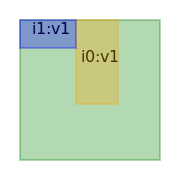

The objective_value_reached is 2.000000.
The mip_gap the solver returns for this solution is 0.0000. This means the solver has proven that
this solution, in term of the objective, is *at most* 0.00% removed from the optimal solution.

-------------------- mip_qubo --------------------


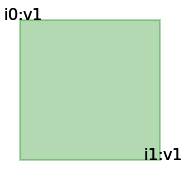

The objective_value_reached is 121144.000000.

-------------------- ann_sw --------------------


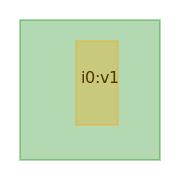


-------------------- ann_hw --------------------


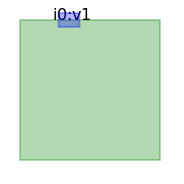

In [16]:
print('In each table rectangle, the number \'i\'-prefixed number refers to the table\'s index')
print('and the \'v\'-prefixed number to the value that table contributes to the objective value.')
for m in run_methods:
    print('\n-------------------- ' + m + ' --------------------')
    display(SVG(svg_filename[m]))
    if m in ['mip_plain', 'mip_qubo']:
        print('The objective_value_reached is {:f}.'.format(objective_value_reached[m]))
        if m == 'mip_plain':
            print('The mip_gap the solver returns for this solution is {:.4f}. This means the solver has proven that'.
                  format(mip_gap_reached[m]))
            print('this solution, in term of the objective, is *at most* {:.2f}% removed from the optimal solution.'.
                  format(100 * mip_gap_reached[m]))    